In [1]:
%matplotlib inline
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import cv
import gc
import random
import matplotlib.pyplot as plt
### What happens when you don't implement any predictions, but instead focus on non-linear interactions as your..
### ..core form of analysis

In [2]:
## Machine Learning Benchmarks
## In linear models a PCA step can work nicely 

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

In [240]:
## Structure Routine Loading and Holdout
df = pd.read_excel("data/Satisfaction Survey.xlsx")

pickle.dump(df, open("data/df_airline.p", "wb"))

In [171]:
### to load holdout for preprocessing to be the same as model processing dataframe 
### df = pickle.load(open("holdout_airline.p", "rb"))

In [100]:
### Some regression problems have a low cardinality and seems like it might be easier to represent as a
### classification problem, instead, I will stick with the regression narrative. 
### I am sure price sensitivity is a self reported measure as it is a survey. 

In [101]:
pd.options.display.max_columns = None

In [102]:
df.head()

,Satisfaction,Airline Status,Age,Age Range,Gender,Price Sensitivity,Year of First Flight,No of Flights p.a.,No of Flights p.a. grouped,% of Flight with other Airlines,Type of Travel,No. of other Loyalty Cards,Shopping Amount at Airport,Eating and Drinking at Airport,Class,Day of Month,Flight date,Airline Code,Airline Name,Orgin City,Origin State,Destination City,Destination State,Scheduled Departure Hour,Departure Delay in Minutes,Arrival Delay in Minutes,Flight cancelled,Flight time in minutes,Flight Distance,Arrival Delay greater 5 Mins
0,3.5,Gold,35,30-39,Male,1,2011,14.923291,11 to 20,5,Business travel,0,0,60,Eco,6,2014-03-06,MQ,EnjoyFlying Air Services,"Madison, WI",Wisconsin,"Dallas/Fort Worth, TX",Texas,6,0.0,0.0,No,119.0,821,no
1,5,Platinum,46,40-49,Female,1,2012,28.800558,21 to 30,24,Business travel,1,0,75,Eco,15,2014-01-15,MQ,EnjoyFlying Air Services,"Milwaukee, WI",Wisconsin,"Dallas/Fort Worth, TX",Texas,10,13.0,0.0,No,114.0,853,no
2,2,Blue,62,60-69,Male,1,2005,63.807531,61 to 70,8,Personal Travel,0,0,30,Eco,24,2014-01-24,MQ,EnjoyFlying Air Services,"Milwaukee, WI",Wisconsin,"Dallas/Fort Worth, TX",Texas,12,0.0,0.0,No,122.0,853,no
3,1,Blue,67,60-69,Female,1,2010,41.841004,41 to 50,5,Personal Travel,0,0,60,Eco,6,2014-03-06,MQ,EnjoyFlying Air Services,"Milwaukee, WI",Wisconsin,"Dallas/Fort Worth, TX",Texas,9,12.0,1.0,No,127.0,853,no
4,4,Blue,44,40-49,Female,1,2003,12.552301,11 to 20,1,Business travel,0,0,90,Business,20,2014-03-20,MQ,EnjoyFlying Air Services,"Madison, WI",Wisconsin,"Chicago, IL",Illinois,9,6.0,24.0,No,30.0,108,yes


In [412]:
# Fits should happen on the train and be applied on test and train
df = pickle.load(open("data/df_airline.p", "rb"))
np.random.seed(10)

df.loc[38897,"Satisfaction"] = 4
df.loc[38898,"Satisfaction"] = 4
df.loc[38899,"Satisfaction"] = 4

df["Satisfaction"] = pd.to_numeric(df["Satisfaction"])

import numpy as np
#Keeping 15% for the validation set, thats about 1000 instances to test on

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in df:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

msk = np.random.rand(len(df)) < 0.30
df["is_test"] = msk

In [413]:
X_train = df[df["is_test"]==False].drop(col_drop,axis=1)
y_train = df[df["is_test"]==False]["Satisfaction"]

test_df = df.loc[df.is_test, :]

msk = np.random.rand(len(test_df)) < 0.50
test_df["is_holdout"] = msk
holdout = test_df[test_df["is_holdout"]==True].reset_index(drop=True).drop("is_holdout",axis=1)
test_df = test_df[test_df["is_holdout"]==False].reset_index(drop=True).drop("is_holdout",axis=1)

X_test = test_df.drop(col_drop, axis=1)
y_test = test_df["Satisfaction"]

X_hold = holdout.drop(col_drop, axis=1)
y_hold = holdout["Satisfaction"]
del holdout

X_full = pd.concat((df[df["is_test"]==False], test_df),axis=0).drop(col_drop, axis=1)
y_full = pd.concat((df[df["is_test"]==False], test_df),axis=0)["Satisfaction"]

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
d_hold = lgb.Dataset(X_hold, label=y_hold)
#d_test = lgb.Dataset(X_test, label=y_test.sample(len(y_test)).reset_index(drop=True)) ## quick bench

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [414]:
y_full.shape

(110343,)

In [415]:
X_full.shape

(110343, 29)

In [347]:
### I doubt these parameters can be improved further - the gap between training and valid has decreased.
### learning curves should not be used to jusde variance and bias - instead to see if more data will help.
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'subsample':.80,
    'num_leaves':50,
    "seed":10,
    'min_data_in_leaf':180,
    'feature_fraction':.80,
    "max_bin":100,
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, }

Fast CV

In [416]:
## Best Score
## Only difference is - this is quick and dirty (Rapid Testing)

## There is a gap between validation and training, so it is overfitting
## Automated is not necessary if you know your parameters - too much of a hastle
## Do anything you can to improve validtion score
## Remember CV is only there for parameter optimisation and that is what you are using it for.
## This is just normal validation and not folder validation
model = lgb.train(params,d_train, num_boost_round=10000,valid_sets=[d_train, d_test], early_stopping_rounds=103,verbose_eval=100,)

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 103 rounds.
[100]	training's l1: 0.505691	valid_1's l1: 0.51388
Early stopping, best iteration is:
[78]	training's l1: 0.507267	valid_1's l1: 0.513656


Medium CV

In [417]:
## Medium Score
## Only difference is - this takes longer but more accurate (Medium Testing)


## Holdout set is (long form testing)

from lightgbm import cv
from lightgbm import Dataset

## Here you don't have to provide a validation set as it will cross validae
def get_score(X, y, usecols, params,seeder,depther, verbose =20):  
     dtrain = Dataset(X[usecols], y)
     # params["max_depth"] = depther

     eval =  cv(params,
             dtrain,
             nfold=3,
             num_boost_round=20000,
             early_stopping_rounds=160, ## After it stopped how long should go on. 
             verbose_eval=verbose,
             stratified=False,  ## by default it is true, so have to set to false
             #verbose_eval=-1,
             seed = seeder,
             show_stdv=True)
     #print(eval)
     return eval, min(eval['l1-mean']), eval["l1-mean"].index(min(eval["l1-mean"]))
  
eval, score, seed_best = get_score(X_full,y_full ,list(X_full.columns), params, seeder=10,depther=6)
print("score: ", score)

[20]	cv_agg's l1: 0.531576 + 0.00124649
[40]	cv_agg's l1: 0.51668 + 0.00128588
[60]	cv_agg's l1: 0.5159 + 0.00137973
[80]	cv_agg's l1: 0.516048 + 0.00141066
[100]	cv_agg's l1: 0.516196 + 0.00134864
[120]	cv_agg's l1: 0.516425 + 0.00133711
[140]	cv_agg's l1: 0.516672 + 0.00123967
[160]	cv_agg's l1: 0.516859 + 0.00126381
[180]	cv_agg's l1: 0.517057 + 0.00117263
[200]	cv_agg's l1: 0.517354 + 0.00125141
[220]	cv_agg's l1: 0.517525 + 0.00128193
score:  0.5158844396077821


Ensemble CV

In [418]:
## Worst Score
## This is a submission CV to identify iterations for the different parameter elections of chosen
## ensemble models. 

random_seeds = [5, 1, 9 ,12, 20]
depths = [6,6,6,6,6]

seed_dict = {}
final_score = 0
for seedling, deepling in zip(random_seeds,depths ):  ## Here is where you add parameter adaptions
    eval, score, seed_best = get_score(X_full,y_full ,list(X_full.columns), params, seeder=seedling,depther=deepling, verbose=-20)
    final_score += score
    seed_dict[seedling] = seed_best
print("score: ", final_score/5)

score:  0.5160619578901716


Fast Submission

In [419]:
y_pred = model.predict(X_hold)

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_hold, y_pred)

0.5135152460923419

In [420]:
n_splits = 5
cvv = KFold(n_splits=n_splits, random_state=42)
oof_preds = np.zeros(X_full.shape[0])

sub = y_hold.to_frame()

sub["Target"] = 0

from sklearn.metrics import mean_absolute_error

feature_importances = pd.DataFrame()
avg_iter = 0

for i, (fit_idx, val_idx) in enumerate(cvv.split(X_full, y_full)):

    X_fit = X_full.iloc[fit_idx]
    y_fit = y_full.iloc[fit_idx]
    X_val = X_full.iloc[val_idx]
    y_val = y_full.iloc[val_idx]
    print(X_full.shape)
    print(X_fit.shape)
    
    model = LGBMRegressor(
**params
    )

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric='mae',
        early_stopping_rounds=150,
        verbose=False
    )
    
    print("itteration: ", model.best_iteration_)
    avg_iter += model.best_iteration_
    oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    sub['Target'] += model.predict(X_hold, num_iteration=model.best_iteration_)
    
    fi = pd.DataFrame()
    fi["feature"] = X_full.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    
    print("Fold {} MAE: {:.8f}".format(i+1, mean_absolute_error(y_val, oof_preds[val_idx])))

print('In Sample MAE score %.8f' % mean_absolute_error(y_full, oof_preds)) 
print('Out of sample MAE: ', mean_absolute_error(y_hold, sub['Target']/n_splits))
print("avg iteration: ",(avg_iter/n_splits))

(110343, 29)
(88274, 29)
itteration:  100
Fold 1 MAE: 0.51615027
(110343, 29)
(88274, 29)
itteration:  100
Fold 2 MAE: 0.51819584
(110343, 29)
(88274, 29)
itteration:  100
Fold 3 MAE: 0.51731088
(110343, 29)
(88275, 29)
itteration:  100
Fold 4 MAE: 0.51331907
(110343, 29)
(88275, 29)
itteration:  100
Fold 5 MAE: 0.51443229
In Sample MAE score 0.51588171
Out of sample MAE:  0.5133541335204654
avg iteration:  100.0


In [ ]:
## Naturally you expect this one to perform somewhat better and ineed it does
## No rediculous improvement, but improvement all the same.

Ensemble Submission

In [421]:
seed_dict

{1: 66, 5: 50, 9: 50, 12: 50, 20: 67}

In [391]:
random_seeds[4]

20

In [386]:
## Everything worked out exactely as I thought. 

5

In [428]:
from sklearn.metrics import mean_absolute_error

sub = y_hold.to_frame()
sub["Target"] = 0

feature_importances = pd.DataFrame()
avg_iter = 0

ba= -1 
for i, r in enumerate(range(n_splits)):
    print(i)
    ba = ba + 1
    
    params["num_boost_round"] = int(seed_dict[random_seeds[ba]]*1.1)
    params["seed"] = random_seeds[ba]
    params["max_depth"] = depths[ba] # if you want to customise uncomment
    
    model = LGBMRegressor(
**params
    )

    model.fit(
        X_full,
        y_full,
        eval_metric='mae',
        verbose=False
    )
    

    sub['Target'] += model.predict(X_hold)
    
    fi = pd.DataFrame()
    fi["feature"] = X_full.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    
print('Out of sample MAE: ', mean_absolute_error(y_hold, sub['Target']/n_splits))



0


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


2


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


3


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


4


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Out of sample MAE:  0.5129196662064283


In [ ]:
1.1 Out of sample MAE:  0.5129196662064283
    

In [392]:
from sklearn.metrics import mean_absolute_error

sub = y_hold.to_frame()
sub["Target"] = 0

feature_importances = pd.DataFrame()
avg_iter = 0

ba= -1 
for i, r in enumerate(range(n_splits)):
    print(i)
    ba = ba + 1
    
    params["num_boost_round"] = seed_dict[random_seeds[ba]]  
    params["seed"] = random_seeds[ba]
    params["max_depth"] = depths[ba] # if you want to customise uncomment
    
    model = LGBMRegressor(
**params
    )

    model.fit(
        X_full,
        y_full,
        eval_metric='mae',
        verbose=False
    )
    

    sub['Target'] += model.predict(X_hold)
    
    fi = pd.DataFrame()
    fi["feature"] = X_full.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    
print('Out of sample MAE: ', mean_absolute_error(y_hold, sub['Target']/n_splits))


0


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


2


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


3


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


4


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Out of sample MAE:  0.5064183766351881


In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_hold, y_pred)
# 0.5163493564074798

In [291]:
eval['l1-mean'][seed_best]

0.5155678000111037

In [217]:
from sklearn.model_selection import learning_curve
from lightgbm import LGBMRegressor
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
## There is no purpose for CV, I have enough data

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument"

<module 'matplotlib.pyplot' from '/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

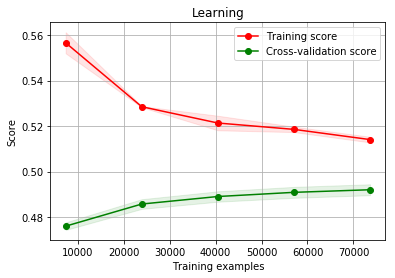

In [201]:
params["num_boost_round"] = 72
### They have converged enough, what this shows is that their is enough data in this task more data != higher score
plot_learning_curve(LGBMRegressor(**params), "Learning", df.drop(col_drop,axis=1), df["Satisfaction"], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

tl;dr when the score is lower than it should be the bias is an issue it is underfitted, when the score is good for training but bad for validation curve then it is overfitting and has too much variance.

Firstly, we should focus on the right side of the plot, where there are sufficient data for evaluation.

    If two curves are "close to each other" and both of them but have a low score. The model suffer from an under fitting problem (High Bias)

    If training curve has a much better score but testing curve has a lower score, i.e., there are large gaps between two curves. Then the model suffer from an over fitting problem (High Variance)


All that has to happen is the cross validation score has to increase and eventually somewhat converge oveer time. If it doesn't you are overfitting. 

I think what you're seeing is normal behaviour:

With only few samples (like 2000) it's easy for a model to (over)fit the data - but it doesn't generalize well. So you get high training accuracy, but the model might not work well with new data (i.e. low validation/test accuracy).

As you add more samples (like 9000) it becomes harder for the model to fit the data - so you get a lower training accuracy, but the model will work better with new data (i.e. validation/test accuracy starts to rise).

So:

    As the training dataset increases, the training accuracy is supposed to decrease because more data is harder to fit well.

    As the training dataset increases, the validation/test accuracy is supposed to increase as well since less overfitting means better generalization.

Andrew Ng has a video about learning curves. Note that he plots the error on the y axis, you have the accuracy on the y axis.. so the y axis is flipped.

Also take a look at the second half of the video. It explains high bias and high variance problems.

Your model seems to have high variance (due to the big "gap" between the two curves) - it's still too complex for the small amount of data you've got. Either getting more data or using a simpler model (or more regularization on the same model) might improve the results.


In [13]:
## Predicting, mean, median, mode, logistic and a groupby

## Metrics
Bring in the holdoutset

In [258]:
y_pred = model.predict(X_hold)

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_hold, y_pred)
# 0.5163493564074798

0.5170065010722477

In [259]:
## Standard Benchmarks

y_mean = y_test.to_frame()
y_mean["Satisfaction"] = y_train.mean()


y_median = y_test.to_frame()
y_median["Satisfaction"] = y_train.median()

y_mode = y_test.to_frame()
y_mode["Satisfaction"] = y_train.mode().values[0]


print("Train")
print("Mean: ",mean_absolute_error(y_test, y_mean),
      "Median: ",mean_absolute_error(y_test, y_median),
      "Mode: ",mean_absolute_error(y_test, y_mode),
      "Random",mean_absolute_error(y_test, y_train.sample(len(y_test)))) 

## Mean Test Distribution Peaking Naive Benchmark (TDPNB)
y_mean = y_test.to_frame()
y_mean["Satisfaction"] = y_test.mean()


# Median TDBPN
y_median = y_test.to_frame()
y_median["Satisfaction"] = y_test.median()

## Mode TDPNB
y_mode = y_test.to_frame()
y_mode["Satisfaction"] = y_test.mode().values[0]
    
print("Test Peaking")
print("Mean: ",mean_absolute_error(y_test, y_mean),
      "Median: ",mean_absolute_error(y_test, y_median),
      "Mode: ",mean_absolute_error(y_test, y_mode),
      "Random",mean_absolute_error(y_test, y_test.sample(len(y_test)))) 

Train
Mean:  0.8252751318191531 Median:  0.8038245451265399 Mode:  0.8038245451265399 Random 1.0412092160197928
Test Peaking
Mean:  0.8248216444238886 Median:  0.8038245451265399 Mode:  0.8038245451265399 Random 1.0403587443946187


In [16]:
## This is going to give Laso some light. 

In [260]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse


def Standardisation(X_train, X_test, leave_out=None):
    from sklearn.preprocessing import StandardScaler
    if leave_out:
        leave = X_train[leave_out]
        X_train = X_train.drop(leave_out,axis=1)

        listed = list(X_train)
        scaler = StandardScaler()
        try:
            X_train = scaler.fit_transform(X_train)
        except:
            print("error_triggered")
            X_train = scaler.fit_transform(X_train.fillna(X_train.mean()))
            X_test = X_test.fillna(X_test.mean())
        
        X_test = scaler.transform(X_test)
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
        X_train.columns = listed
        X_train = pd.concat((X_train,leave ),axis=1)
        X_test.columns = listed
        X_test = pd.concat((X_test,leave ),axis=1)
    else:
        scaler = StandardScaler()
        listed = list(X_train)
        try:
            X_train = scaler.fit_transform(X_train)
        except:
            print("error_triggered")
            X_train = scaler.fit_transform(X_train.fillna(X_train.mean()))
            X_test = X_test.fillna(X_test.mean())
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test)
        X_test.columns = listed
        
        X_train = pd.DataFrame(X_train)
        X_train.columns = listed
        
    return X_train, X_test

X_train_s, X_test_s = Standardisation(X_train,X_test,[])
_, X_hold_s = Standardisation(X_train,X_hold,[])



error_triggered
error_triggered


In [261]:
## This is a quick and dirty way to do cs for lasso without plotting, but I want to plot the alphas, see below.
## Alpha is simply the regularisation term
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train_s, y_train)

Below we'll run a ridge regression and see how score varies with different alphas. This will show how picking a different alpha score changes the R2.

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

    α = 0:
        The objective becomes same as simple linear regression.
        We’ll get the same coefficients as simple linear regression.
    α = ∞:
        The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.
    0 < α < ∞:
        The magnitude of α will decide the weightage given to different parts of objective.
        The coefficients will be somewhere between 0 and ones for simple linear regression.


In [ ]:
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
#ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8) ## too computationally expensive
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [23]:
## This is a great score without hyper-parametr tampering. 
svr = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000).fit(X_train_s, y_train)
y_svr = svr.predict(X_test_s)
mean_absolute_error(y_test, y_svr)
# 0.5006963184228322

0.5006963184228322

In [ ]:
ela = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009).fit(X_train_s, y_train)
y_ela = ela.predict(X_test_s)
mean_absolute_error(y_test, y_ela)

In [ ]:
bay = BayesianRidge().fit(X_train_s, y_train)
y_bay = bay.predict(X_test_s)
mean_absolute_error(y_test, y_bay)

In [ ]:
score_kernel_ridge = [] 
alpha_space = np.logspace(-1, 0, 3)
for r in alpha_space:
    kr = KernelRidge(alpha= r, kernel="polynomial", degree=3).fit(X_train_s, y_train)

    y_kr = kr.predict(X_test_s)

    score_kernel_ridge.append(mean_absolute_error(y_test, y_kr))

In [ ]:
score_lasso = [] 
alpha_space = np.logspace(-10, 0, 20)
for r in alpha_space:
    lasso = Lasso(alpha= r, normalize=True).fit(X_train_s, y_train)

    y_lasso = lasso.predict(X_test_s)

    score_lasso.append(mean_absolute_error(y_test, y_lasso))

In [ ]:
score_lasso

In [ ]:
score = [] 
alpha_space = np.logspace(-4, 0, 20)
for r in alpha_space:
    ridge = Ridge(alpha= r, normalize=True).fit(X_train_s, y_train)

    y_ridge = ridge.predict(X_test_s)

    score.append(mean_absolute_error(y_test, y_ridge))

In [ ]:
score

In [ ]:
ridge_cv_scores = cross_val_score(ridge, X_scaled, y_train, cv=10)

In [ ]:
ridge_cv_scores

In [ ]:
score

In [ ]:
score

In [ ]:
from sklearn.linear_model import Ridge

# Create an array of alphas and lists to store scores
alpha_space = np.logspace(-20, 0, 10)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_scaled, y_train, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Use this function to create a plot    
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [ ]:
import matplotlib
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")



imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])



matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
df.shape

In [ ]:
## Scaled Data

## PCA Data
pca = PCA(n_components=410)
X_scaled=pca.fit_transform(X_scaled)

In [ ]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse


def Standardisation(df, leave_out=None):
    from sklearn.preprocessing import StandardScaler
    if leave_out:
        leave = df[leave_out]
        df = df.drop(leave_out,axis=1)

        listed = list(df)
        scaler = StandardScaler()
        try:
            scaled = scaler.fit_transform(df)
        except:
            print("error_triggered")
            scaled = scaler.fit_transform(df.fillna(df.mean()))
        df = pd.DataFrame(scaled)
        df.columns = listed
        df = pd.concat((df,leave ),axis=1)
    else:
        scaler = StandardScaler()
        listed = list(df)
        try:
            scaled = scaler.fit_transform(df)
        except:
            print("error_triggered")
            scaled = scaler.fit_transform(df.fillna(df.mean()))
        df = pd.DataFrame(scaled)
        df.columns = listed
    return df



X_scaled = Standardisation(X_train,[])

In [ ]:
X_scaled.shape

In [ ]:
y_train.shape

In [ ]:
## Machine Learning Benchmarks
## In linear models a PCA step can work nicely 

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_train.reset_index(drop=True))
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

In [ ]:
1+1

In [ ]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)


In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

In [ ]:
p_testa

In [ ]:
## It has been a long time sinced I used learning curves, and I think it is worth adding one again, and saying something about how much data is needed

In [ ]:
Learning Curves: If you plot cross-validation (cv) error and training set error rates versus training set size, you can learn a lot. If the two curves approach each other with low error rate, then you are doing well.

If it looks like the curves are starting to approach each other and both heading/staying low, then you need more data.

If the cv curve remains high, but the training set curve remains low, then you have a high-variance situation. You can either get more data, or use regularization to improve generalization.